# Chapter 2: Time series graphics

Load common libraries and settings:

In [1]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*FigureCanvasAgg is non-interactive.*"
)
import os
os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
np.set_printoptions(suppress=True)
np.random.seed(1)
import random
random.seed(1)
import pandas as pd
pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
from utilsforecast.plotting import plot_series as plot_series_utils
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
from fpppy.utils import plot_series

Load additional libraries:

In [2]:
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

## 2.1 `DataFrame` Objects

### The index variables

A time series is a list of numbers indexed by a time step. 

In [3]:
x = [123, 39, 78, 52, 110]
yr = list(range(2015, 2020))
df = pd.DataFrame({"Year": yr, "Observation": x})
df.set_index("Year", inplace=True)
df

,Observation
Year,
2015,123
2016,39
2017,78
2018,52
2019,110


In [4]:
df.columns

Index(['Observation'], dtype='str')

### The key variables

In [5]:
olympic_running = pd.read_csv("./data/olympic_running_unparsed.csv")
olympic_running.head(10)

,Year,Length,Sex,Time
0,1896,100,men,12.0
1,1900,100,men,11.0
2,1904,100,men,11.0
3,1908,100,men,10.8
4,1912,100,men,10.8
5,1916,100,men,NaN
6,1920,100,men,10.8
7,1924,100,men,10.6
8,1928,100,men,10.8
9,1932,100,men,10.3


In [6]:
olrun = olympic_running.copy()
olrun.shape

(312, 4)

In [7]:
olrun.columns

Index(['Year', 'Length', 'Sex', 'Time'], dtype='str')

In [8]:
olrun['Sex'].unique()

<StringArray>
['men', 'women']
Length: 2, dtype: str

In [9]:
olrun['Length'].unique()

array([  100,   200,   400,   800,  1500,  5000, 10000])

### Working with timeseries dataframes

In [10]:
pbs = pd.read_csv("./data/PBS_unparsed.csv")        # sales data on pharma products in Australia
pbs['Month'] = pd.to_datetime(pbs['Month'])
pbs.head()

,Month,Concession,Type,ATC1,ATC1_desc,ATC2,ATC2_desc,Scripts,Cost
0,1991-07-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,18228,67877.0
1,1991-08-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15327,57011.0
2,1991-09-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14775,55020.0
3,1991-10-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15380,57222.0
4,1991-11-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14371,52120.0


In [11]:
pbs.shape

(67596, 9)

In [12]:
a10 = pbs.query('ATC2 == "A10"')    # select *rows* corresponding to diabetes drugs (ATC code A10)
a10 = a10.filter(['Month', 'Concession', 'Type', 'Cost'])   # Select only some *columns* for analysis
a10.head()

,Month,Concession,Type,Cost
1524,1991-07-01,Concessional,Co-payments,2.093e+06
1525,1991-08-01,Concessional,Co-payments,1.796e+06
1526,1991-09-01,Concessional,Co-payments,1.777e+06
1527,1991-10-01,Concessional,Co-payments,1.849e+06
1528,1991-11-01,Concessional,Co-payments,1.686e+06


The `df.filter()` method differs from the `df.loc()` method in that the former is primarily used for subsetting rows or columns based on matching criteria in their labels, e.g. partial string matching, regex, `items`, `like`, etc, whereas the latter selects data by explicit row/column labels or boolean conditions. `filter()` doesn't filter based on content, only on labels of the index; `loc()` can filter based on the content (values) with the df e.g. `df.loc(df['col']>5).

The `agg()` method allows us to aggregate data across keys, e.g. in computing the total cost per month regardless of `Concession` and `Type`.

In [13]:
total_cost_df = a10.groupby('Month', as_index=False).agg({'Cost': 'sum'})
total_cost_df.rename(columns={'Cost': 'TotalC'}, inplace=True)
total_cost_df.head()

,Month,TotalC
0,1991-07-01,3.527e+06
1,1991-08-01,3.181e+06
2,1991-09-01,3.252e+06
3,1991-10-01,3.611e+06
4,1991-11-01,3.566e+06


In [14]:
total_cost_df.shape

(204, 2)

We can see now that the dataset spans 204 months. We can also create new variables using `assign()`, e.g. changing units from dollars to millions of dollars:

In [15]:
total_cost_df = total_cost_df.assign(
    Cost = round(total_cost_df['TotalC'] / 1e6, 2)
)
total_cost_df.head()

,Month,TotalC,Cost
0,1991-07-01,3.527e+06,3.53
1,1991-08-01,3.181e+06,3.18
2,1991-09-01,3.252e+06,3.25
3,1991-10-01,3.611e+06,3.61
4,1991-11-01,3.566e+06,3.57


In [16]:
total_cost_df.to_csv('./data/total_cost_df.csv', index=False)

### Read a csv file

Quarterly data for the prison population in Australia, disaggregated by state, gender, legal status, and indigenous status (ATSI = Aboriginal or Torres Strait Islander):

In [17]:
prison = pd.read_csv('./data/prison_population.csv')
prison.head()

,Date,State,Gender,Legal,Indigenous,Count
0,2005-03-01,ACT,Female,Remanded,ATSI,0
1,2005-03-01,ACT,Female,Remanded,Non-ATSI,2
2,2005-03-01,ACT,Female,Sentenced,ATSI,0
3,2005-03-01,ACT,Female,Sentenced,Non-ATSI,5
4,2005-03-01,ACT,Male,Remanded,ATSI,7


The dates are stored as individual days, but the data is actually quarterly, so we need to convert `Date` to quarters.

In [18]:
prison['Date'] = pd.to_datetime(prison['Date'])         # Convert 'Date' from string to datetime
prison['Quarter'] = prison['Date'].dt.to_period('Q')    # Create col. 'Quarter' by converting 'Date' to quarters
prison = prison.drop(columns=['Date'])                  # Drop the original 'Date' column, not needed anymore
prison.set_index('Quarter', inplace=True)               # Set 'Quarter' as the index of the dataframe
prison.sort_values(by=['State', 'Gender', 'Legal', 'Indigenous'])    # Sort by the specified columns in ascending order
prison.head()

,State,Gender,Legal,Indigenous,Count
Quarter,,,,,
2005Q1,ACT,Female,Remanded,ATSI,0
2005Q1,ACT,Female,Remanded,Non-ATSI,2
2005Q1,ACT,Female,Sentenced,ATSI,0
2005Q1,ACT,Female,Sentenced,Non-ATSI,5
2005Q1,ACT,Male,Remanded,ATSI,7


### The seasonal period

## 2.2 Time plots

The obvious graph to start with is a plot of observations vs. time index. Consecutive observations are often joined by straight lines. The following plot will show the weekly economy passenger load on Ansett airlines between Melbourne and Sydney.

In [19]:
ansett = pd.read_csv('./data/ansett.csv')
ansett.head()

,ds,Airports,Class,y
0,1989-07-10,ADL-PER,Business,193
1,1989-07-17,ADL-PER,Business,254
2,1989-07-24,ADL-PER,Business,185
3,1989-07-31,ADL-PER,Business,254
4,1989-08-07,ADL-PER,Business,191


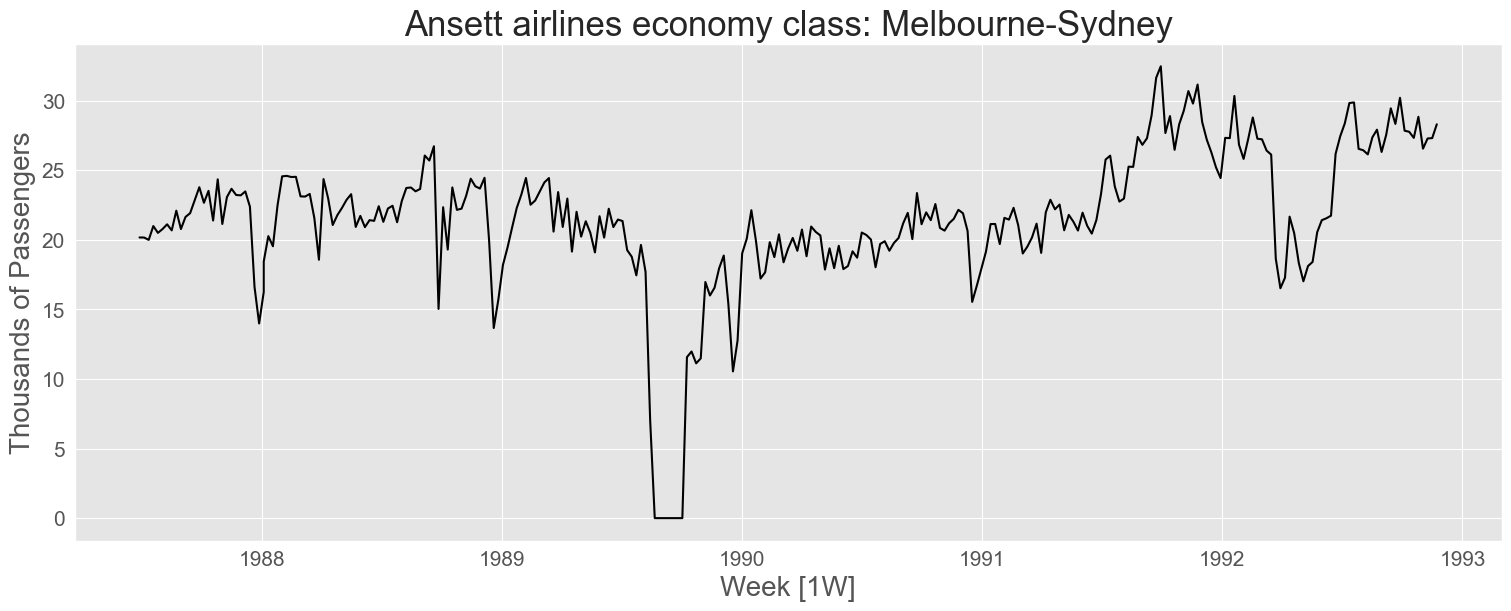

In [ ]:
ansett['ds'] = pd.to_datetime(ansett['ds'])
melsyd_economy = ansett.query(
    'Airports == "MEL-SYD" & Class == "Economy"'
).copy()
melsyd_economy['y'] = melsyd_economy['y'] / 1000
plot_series(                                            # from utilsforecast library
    df = melsyd_economy,
    id_col = 'Airports',
    time_col = 'ds',
    target_col = 'y',
    ylabel = 'Thousands of Passengers',
    xlabel = 'Week [1W]',
    title = 'Ansett airlines economy class: Melbourne-Sydney'
)

Note:
- There was a period in 1989 where zero passengers were carried. This was due to an industrial dispute shutting down the airline.
- There was a period of reduced load in 1992, bucking the trend. This was due to a trial in which some economy class seats were replaced by business class seats.
- A large increase in passenger load occurred in the second half of 1991.
- There are some large dips in load around the start of each year, due to holiday effects.
- There is a long-term fluctuation in which the series trends upward in 1987, downward in 1989, and increases again through 1990 and 1991. 

Any model needs to take these features into account to make an effective forecast. 

Now we can plot the `total_cost_df` that we made earlier:

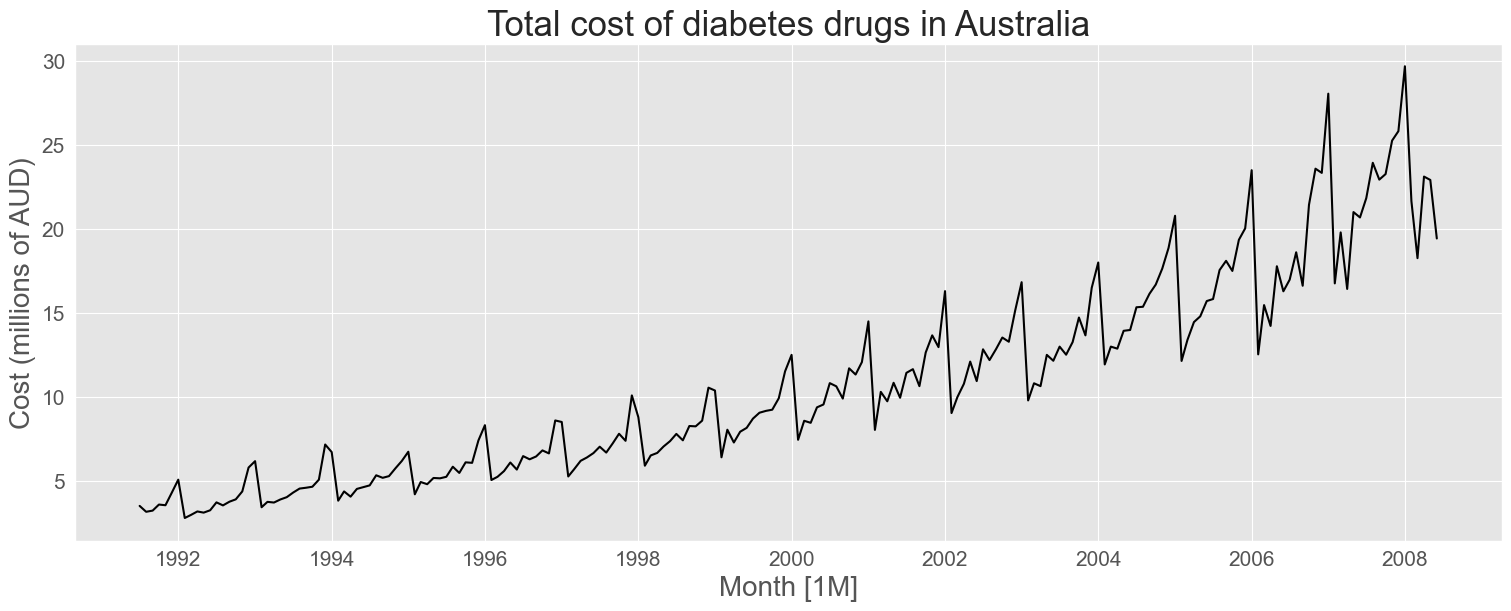

In [22]:
total_cost_df['unique_id'] = 'total_cost'       # Create a unique id column for the plot_series method
plot_series(
    df = total_cost_df,
    id_col = 'unique_id',
    time_col = 'Month',
    target_col = 'Cost',
    ylabel = 'Cost (millions of AUD)',
    xlabel = 'Month [1M]',
    title = 'Total cost of diabetes drugs in Australia'
)

Note the clear and increasing trend, as well as the strong seasonal pattern that increases in amplitude over time. The sudden drop at the start of the year is due to a government subsidization scheme that makes it cost-effective for patients to stockpile drugs at the end of the calendar year. Any forecasts need to capture the trend and the seasonal pattern. 

## 2.3 Time series patterns

- **Trend**
    - A trend exists when there's a long term increase/decrease in the data, but it doesn't have to be linear. 
- **Seasonal**
    - A seasonal pattern occurs when a time series is affected by time of they year, day of the week, hour of the day, etc. Seasonality is always of fixed and known period, though more than one seasonal pattern can exist simultaneously. 
- **Cyclic**
    - A cycle occurs when the data rises and falls absent a fixed frequency, usually due to economic conditions related to the "business cycle". The duration of these is typically around 2 years. 

## 2.4 Seasonal Plots

Similar to a time plot except the data are plotted against the individual "seasons" in which the data were observed. For example, using the antidiabetic drug sales:

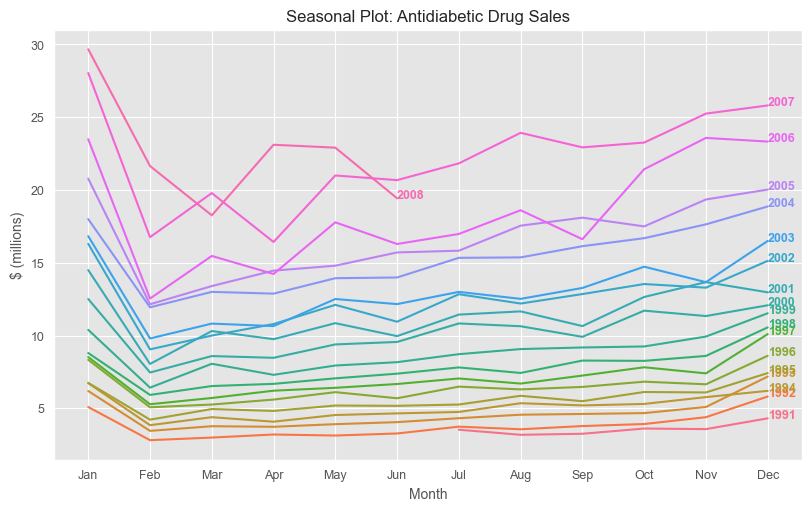

In [24]:
total_cost_df['Month_name'] = total_cost_df['Month'].dt.strftime('%b')  # Extract month name from 'Month' column
total_cost_df['Year'] = total_cost_df['Month'].dt.year                  # Extract year from 'Month' column
total_cost_df['Month_num'] = total_cost_df['Month'].dt.month            # Extract month number from 'Month' column
unique_years = total_cost_df['Year'].unique()

year_palette = sns.color_palette("husl", n_colors=len(unique_years))
fig, ax = plt.subplots()
sns.lineplot(data=total_cost_df,
  x="Month_num", y="Cost",
  hue="Year", palette=year_palette, legend=False, ax=ax,
)
ax.set_title("Seasonal Plot: Antidiabetic Drug Sales")
ax.set_xlabel("Month")
ax.set_ylabel("$ (millions)")
ax.set_xticks(
  ticks=range(1, 13),
  labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
)

min_year = unique_years.min()
for year, subset in total_cost_df.groupby("Year"):
  ax.text(
    subset["Month_num"].iloc[-1],
    subset["Cost"].iloc[-1],
    str(year),
    fontsize=9,
    weight="bold",
    color=year_palette[year - min_year],
  )
fig.show()